In [25]:
# Import Libraries
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [57]:
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("JSON version:", json.__version__) # Might not be directly accessible as a version

TensorFlow version: 2.17.1
NumPy version: 1.26.4
JSON version: 2.0.9


In [2]:
# Import Data
with open("dataset_findup.json", "r") as file:
    data = json.load(file)

In [3]:
# Load Pretrained Model
def load_model_and_tokenizer(model_name="distilbert-base-uncased"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModel.from_pretrained(model_name)
    return tokenizer, model

In [4]:
tokenizer, pretrained_model = load_model_and_tokenizer()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [5]:
# Extract Candidate Embeddings
def extract_embeddings(data, tokenizer, model):
    paragraphs = []
    for person in data:
        for name, details in person.items():
            skills = ", ".join(details['Skills'])
            work_experience = " ".join([
                f"{exp['Position']} at {exp['Company Name']} ({exp['Start Date']} - {exp['End Date']}): {' '.join(exp['Description'])}"
                for exp in details['Work Experience']
            ])
            certifications = ", ".join(details['Certification'])

            paragraph = (
                f"{name} is a {details['Personal Info']['Degree']} with expertise in {skills}. "
                f"Work experience includes {work_experience.strip()} "
                f"and certifications such as {certifications}."
            )
            paragraphs.append(paragraph)

    inputs = tokenizer(paragraphs, padding=True, truncation=True, return_tensors="tf")
    embeddings = tf.reduce_mean(model(inputs)[0], axis=1).numpy()
    return paragraphs, embeddings


In [6]:
paragraphs, candidate_embeddings = extract_embeddings(data, tokenizer, pretrained_model)

In [7]:
# Apply KMeans Clustering
def apply_kmeans(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans

In [8]:
num_clusters = 10  # Set the number of clusters based on job roles or domain knowledge
kmeans = apply_kmeans(candidate_embeddings, num_clusters)

In [9]:
# Annotate Clusters with Job Roles
def annotate_clusters(kmeans, paragraphs):
    cluster_assignments = kmeans.labels_
    clustered_paragraphs = {i: [] for i in range(kmeans.n_clusters)}
    for idx, cluster in enumerate(cluster_assignments):
        clustered_paragraphs[cluster].append(paragraphs[idx])
    return clustered_paragraphs

In [10]:
clustered_paragraphs = annotate_clusters(kmeans, paragraphs)

In [11]:
# Prepare Data for Fine-Tuning
def prepare_fine_tuning_data(data, tokenizer, kmeans):
    examples = []
    labels = []
    for paragraph, label in zip(paragraphs, kmeans.labels_):
        examples.append(paragraph)
        labels.append(label)

    tokenized = tokenizer(examples, padding=True, truncation=True, return_tensors="tf")
    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=kmeans.n_clusters)

    dataset = tf.data.Dataset.from_tensor_slices(
        ({
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"]
        }, labels_one_hot)
    ).batch(8).prefetch(tf.data.AUTOTUNE)

    return dataset

In [12]:
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = prepare_fine_tuning_data(train_data, tokenizer, kmeans)
valid_dataset = prepare_fine_tuning_data(valid_data, tokenizer, kmeans)

In [16]:
# Fine-Tune the Model
def build_fine_tuning_model(base_model, num_classes, learning_rate=2e-3):
    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

    embeddings = base_model([input_ids, attention_mask])[0]
    pooled_output = tf.reduce_mean(embeddings, axis=1)

    dense1 = tf.keras.layers.Dense(256, activation="relu")(pooled_output)
    dropout1 = tf.keras.layers.Dropout(0.3)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.3)(dense2)

    output = tf.keras.layers.Dense(num_classes, activation="softmax")(pooled_output)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [19]:
num_classes = num_clusters
fine_tuning_model = build_fine_tuning_model(pretrained_model, num_classes)

In [21]:
history = fine_tuning_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=4
)

Epoch 1/4
13/13 [==============================] - 351s 26s/step - loss: 0.6999 - accuracy: 0.7100 - val_loss: 0.5371 - val_accuracy: 0.7700
Epoch 2/4
13/13 [==============================] - 327s 26s/step - loss: 0.5686 - accuracy: 0.8100 - val_loss: 0.4140 - val_accuracy: 0.8200
Epoch 3/4
13/13 [==============================] - 332s 26s/step - loss: 0.4474 - accuracy: 0.8100 - val_loss: 0.3106 - val_accuracy: 0.8700
Epoch 4/4
13/13 [==============================] - 331s 26s/step - loss: 0.3481 - accuracy: 0.8700 - val_loss: 0.2610 - val_accuracy: 0.8900


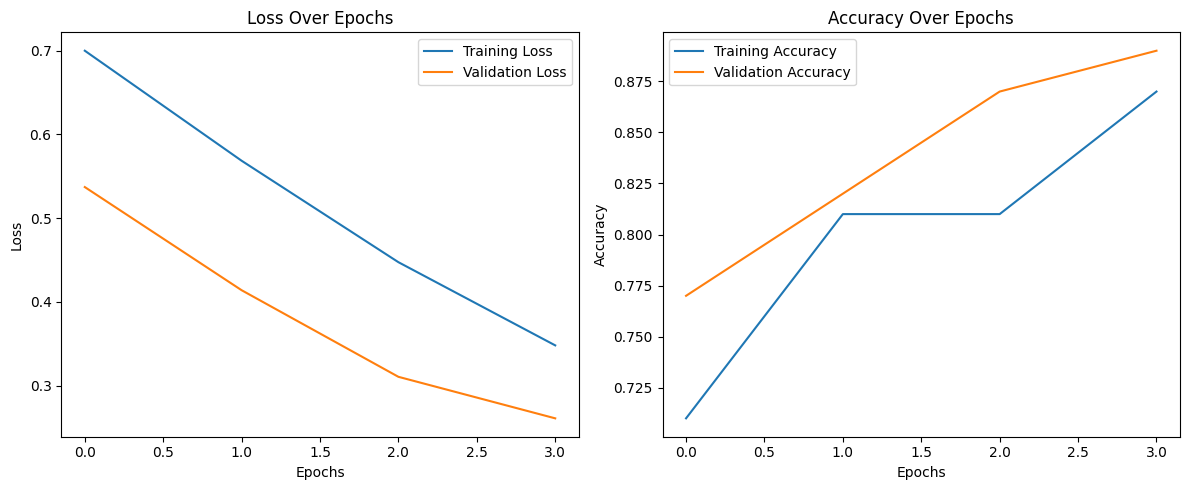

In [24]:
# Visualize Training and Validation Loss/Accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call after training
plot_training_history(history)

In [29]:
# Generate Predictions and True Labels
def plot_confusion_matrix(model, dataset, true_labels, num_classes):
    predictions = model.predict(dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)  # Convert one-hot to categorical

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()


13/13 [==============================] - 100s 7s/step


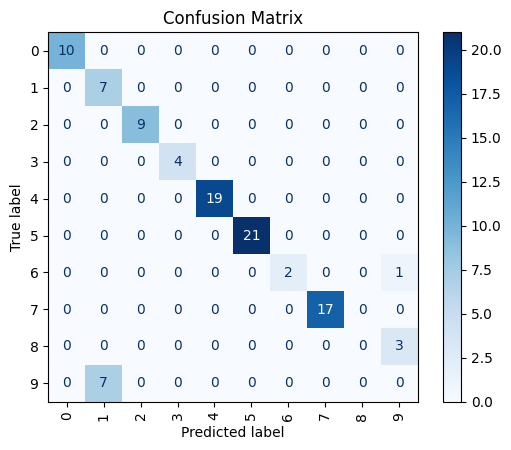

In [60]:
# Get validation labels
valid_labels = []
for _, label in valid_dataset:
    valid_labels.extend(label.numpy())

valid_labels = np.array(valid_labels)

# Call this after training
num_classes = kmeans.n_clusters  # Ensure this matches the number of clusters
plot_confusion_matrix(fine_tuning_model, valid_dataset, valid_labels, num_classes)

In [32]:
print(kmeans.n_clusters)

10


In [36]:
cv_gilang = {
        "GILANG ADITYA": {
            "Personal Info": {
                "Phone Number": "+626491310049",
                "Email": "gilangaditya@gmail.com",
                "Github": "github.com/gilangaditya",
                "LinkedIn": "https://www.linkedin.com/in/gilangaditya/",
                "Degree": "Bachelor's in Information Technology"
            },
            "Skills": [
                "UI/UX Design",
                "JavaScript",
                "HTML",
                "Google Cloud",
                "AWS",
                "PostgreSQL",
                "Machine Learning",
                "MySQL"
            ],
            "Work Experience": [
                {
                    "Company Name": "DevPath",
                    "Start Date": "Apr 2023",
                    "End Date": "Mar 2024",
                    "Position": "Product Manager",
                    "Description": [
                        "I utilized various technologies and methodologies, further enhancing my expertise in software development.",
                        "Throughout my tenure, I took the initiative in leading team retrospectives.",
                        "I played a key role in enhancing user experience which contributed to our project successes."
                    ]
                },
                {
                    "Company Name": "CodeSpace",
                    "Start Date": "May 2016",
                    "End Date": "Oct 2016",
                    "Position": "Frontend Developer",
                    "Description": [
                        "My experience included mentoring junior team members and fostering a collaborative work environment.",
                        "I played a key role in optimizing our workflows which contributed to our project successes."
                    ]
                },
                {
                    "Company Name": "TechNation",
                    "Start Date": "Aug 2017",
                    "End Date": "Jul 2022",
                    "Position": "Frontend Developer",
                    "Description": [
                        "Throughout my tenure, I took the initiative in collaborating with stakeholders.",
                        "I was responsible for leading initiatives that improved our development processes.",
                        "My experience included mentoring junior team members and fostering a collaborative work environment.",
                        "I utilized various technologies and methodologies, further enhancing my expertise in data analysis.",
                        "I played a key role in optimizing our workflows which contributed to our project successes.",
                        "At this role, I leveraged my skills in team collaboration to deliver excellent results."
                    ]
                }
            ],
            "Certification": []
        }
    }

In [39]:
# Extract Embeddings for a Single Input
def extract_single_embedding(person, tokenizer, model):
    # Extract details from the input dictionary
    name = list(person.keys())[0]
    details = person[name]

    # Generate text description
    skills = ", ".join(details['Skills'])
    work_experience = " ".join([
        f"{exp['Position']} at {exp['Company Name']} ({exp['Start Date']} - {exp['End Date']}): {' '.join(exp['Description'])}"
        for exp in details['Work Experience']
    ])
    certifications = ", ".join(details['Certification'])

    paragraph = (
        f"{name} is a {details['Personal Info']['Degree']} with expertise in {skills}. "
        f"Work experience includes {work_experience.strip()} "
        f"and certifications such as {certifications}."
    )

    # Tokenize and get embeddings
    inputs = tokenizer(paragraph, padding=True, truncation=True, return_tensors="tf")
    embedding = tf.reduce_mean(model(inputs)[0], axis=1).numpy()

    return paragraph, embedding

In [41]:
# Get embedding for the single input
paragraph, embedding = extract_single_embedding(cv_gilang, tokenizer, pretrained_model)

In [47]:
# Extract Embedding and Predict for a Single JSON Input
def predict_from_json(input_json, tokenizer, model, kmeans_labels):
    # Extract person details from the JSON
    name = list(input_json.keys())[0]
    details = input_json[name]

    # Generate text description
    skills = ", ".join(details['Skills'])
    work_experience = " ".join([
        f"{exp['Position']} at {exp['Company Name']} ({exp['Start Date']} - {exp['End Date']}): {' '.join(exp['Description'])}"
        for exp in details['Work Experience']
    ])
    certifications = ", ".join(details['Certification']) if details['Certification'] else "none"

    paragraph = (
        f"{name} is a {details['Personal Info']['Degree']} with expertise in {skills}. "
        f"Work experience includes {work_experience.strip()} "
        f"and certifications such as {certifications}."
    )

    # Tokenize and get embedding
    inputs = tokenizer(paragraph, padding=True, truncation=True, return_tensors="tf")
    predictions = model(inputs)
    predicted_class = tf.argmax(predictions, axis=1).numpy()[0]

    # Map index to label
    predicted_label = kmeans_labels[predicted_class]

    # Return processed text and predictions
    return paragraph, predicted_label

In [48]:
kmeans_labels = [
    "Frontend Developer",
    "Backend Developer",
    "Data Scientist",
    "Product Manager",
    "UI/UX Designer",
    "Cloud Engineer",
    "Machine Learning Engineer",
    "Database Administrator",
    "Full Stack Developer",
    "Software Engineer"
]

In [49]:
# Generate predictions
paragraph, predictions = predict_from_json(cv_gilang, tokenizer, fine_tuning_model, kmeans_labels)

In [50]:
# Display results
print("Generated Text Description:")
print(paragraph)
print("\nModel Predictions:")
print(predictions)

Generated Text Description:
GILANG ADITYA is a Bachelor's in Information Technology with expertise in UI/UX Design, JavaScript, HTML, Google Cloud, AWS, PostgreSQL, Machine Learning, MySQL. Work experience includes Product Manager at DevPath (Apr 2023 - Mar 2024): I utilized various technologies and methodologies, further enhancing my expertise in software development. Throughout my tenure, I took the initiative in leading team retrospectives. I played a key role in enhancing user experience which contributed to our project successes. Frontend Developer at CodeSpace (May 2016 - Oct 2016): My experience included mentoring junior team members and fostering a collaborative work environment. I played a key role in optimizing our workflows which contributed to our project successes. Frontend Developer at TechNation (Aug 2017 - Jul 2022): Throughout my tenure, I took the initiative in collaborating with stakeholders. I was responsible for leading initiatives that improved our development pro

In [62]:
fine_tuning_model.save('text_similarity.h5')
print('Model saved as my_model.h5!')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as my_model.h5!
